In [1]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
torch.cuda.is_available()

True

### Utils

In [4]:
class ConvBlock(nn.Module):
    """
    Simple convolutional block: Conv + Norm + Act + Dropout
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, add_norm=True, activation="ReLU", dropout=None, pad = 1):
        """ Module Initializer """
        super().__init__()
        assert activation in ["ReLU", "LeakyReLU", "Sigmoid", "Tanh", None]
        
        block = []
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=pad, stride=stride))
        if add_norm:
            block.append(nn.BatchNorm2d(out_channels))
        if activation is not None:
            nonlinearity = getattr(nn, activation, nn.ReLU)()
            if isinstance(nonlinearity, nn.LeakyReLU):
                nonlinearity.negative_slope = 0.2
            block.append(nonlinearity)
            
        if dropout is not None:
            block.append(nn.Dropout(dropout))
            
        self.block =  nn.Sequential(*block)

    def forward(self, x):
        """ Forward pass """
        y = self.block(x)
        return y


class ConvTransposeBlock(nn.Module):
    """
    Simple convolutional block: ConvTranspose + Norm + Act + Dropout
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, add_norm=True, activation="ReLU", dropout=None, pad =1):
        """ Module Initializer """
        super().__init__()
        assert activation in ["ReLU", "LeakyReLU", "Tanh", None]
        
        
        block = []
        block.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=pad, stride=stride))
        if add_norm:
            block.append(nn.BatchNorm2d(out_channels))
        if activation is not None:
            nonlinearity = getattr(nn, activation, nn.ReLU)()
            if isinstance(nonlinearity, nn.LeakyReLU):
                nonlinearity.negative_slope = 0.2
            block.append(nonlinearity)
        if dropout is not None:
            block.append(nn.Dropout(dropout))
            
        self.block =  nn.Sequential(*block)

    def forward(self, x):
        """ Forward pass """
        y = self.block(x)
        return y


class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)


In [5]:
# utils
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def visualize_progress(total_d_loss_fake, total_d_loss_real, total_gan_loss, g_loss_curve, d_loss_curve, total_d_loss):
    """ Visualizing loss and accuracy """
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(30,5)

    smooth_loss1 = smooth(total_d_loss_fake, 31)
    smooth_loss2 = smooth(total_d_loss_real, 31)
    ax[0].plot(smooth_loss1, c="blue", label="Fake D Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss2, c="red", label="Real D Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_yscale("log")
    ax[0].set_title("Training Progress of Discriminator")

    smooth_loss1 = smooth(total_d_loss, 31)
    smooth_loss2 = smooth(total_gan_loss, 31)
    START = 500
    N_ITERS = len(total_d_loss)
    ax[1].plot(np.arange(START, N_ITERS), smooth_loss1[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(np.arange(START, N_ITERS), smooth_loss2[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("Loss")
    ax[1].set_yscale("log")
    ax[1].set_title(f"Training Progress from Iter {START}")

    epochs = np.arange(len(g_loss_curve)) + 1
    ax[2].plot(epochs[1:], g_loss_curve[1:], c="red", label="Train Loss", linewidth=3)
    ax[2].plot(epochs[1:], d_loss_curve[1:], c="blue", label="Valid Loss", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("Loss")
    ax[2].set_title("Loss Curves")


    plt.show()


#### Function to calculate FID (Frechet Inception Distance)
Source: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/ @ Jason Brown Lee, PhD

In [6]:
from scipy.linalg import sqrtm

def calculate_fid(real_features, generated_features):
    mu_r = np.mean(real_features, axis=0)
    mu_g = np.mean(generated_features, axis=0)
    sigma_r = np.cov(real_features, rowvar=False)
    sigma_g = np.cov(generated_features, rowvar=False)
    
    diff = mu_r - mu_g
    covmean, _ = sqrtm(sigma_r.dot(sigma_g), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma_r + sigma_g - 2 * covmean)
    return fid



In [7]:
class Reshape(nn.Module):
    """ Reshaping a vector in a given shape """
    
    def __init__(self, shape):
        """ """
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        """ """
        B, N = x.shape
        x = x.view(B, N, 1, 1)
        y = x.repeat(1, 1, *self.shape)
        return y

## DCGAN with CelebA

In [8]:
if not os.path.exists("Lab Work/CUDA_Assignment_6/imgs/DCGAN"):
    os.makedirs("Lab Work/CUDA_Assignment_6/imgs/DCGAN")
if os.path.exists("Lab Work/CUDA_Assignment_6/imgs/DCGAN/training"):
    shutil.rmtree("Lab Work/CUDA_Assignment_6/imgs/DCGAN/training")
if not os.path.exists("Lab Work/CUDA_Assignment_6/imgs/DCGAN/training"):
    os.makedirs("Lab Work/CUDA_Assignment_6/imgs/DCGAN/training")

## Loading the CelebA dataset

Stanford Dataset retrieved from kaggle.com/datasets/jessicali9530/celeba-dataset

In [9]:
# !pip install kaggle
# kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

In [10]:
from torch.utils.data import Dataset
import pandas as pd

In [11]:

class CelebADataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Load the data
        self.attrs = pd.read_csv(os.path.join(root_dir, 'list_attr_celeba.csv'))
        self.bbox = pd.read_csv(os.path.join(root_dir, 'list_bbox_celeba.csv'))
        self.landmarks = pd.read_csv(os.path.join(root_dir, 'list_landmarks_align_celeba.csv'))
        self.partitions = pd.read_csv(os.path.join(root_dir, 'list_eval_partition.csv'))

        # Filter by split
        if split == 'train':
            self.data = self.partitions[self.partitions['partition'] == 0]
        elif split == 'valid':
            self.data = self.partitions[self.partitions['partition'] == 1]
        elif split == 'test':
            self.data = self.partitions[self.partitions['partition'] == 2]
        else:
            raise ValueError("Split must be 'train', 'valid', or 'test'")

        # Merge the attributes with the filtered partition data
        self.data = self.data.merge(self.attrs, on='image_id')
        self.data = self.data.merge(self.bbox, on='image_id')
        self.data = self.data.merge(self.landmarks, on='image_id')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, 'img_align_celeba', 'img_align_celeba', self.data.iloc[idx, 0])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        # Convert attributes to tensor
        attributes = self.data.iloc[idx, 1:].values.astype('int')
        attributes = torch.tensor(attributes, dtype=torch.float32)

        return image, attributes

# Define the transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalizing around 0 with a range of [-1, 1]
    ]),
}

# Create the datasets
train_dataset = CelebADataset(root_dir='/home/user/krishnanm0/dataset', split='train', transform=data_transforms['train'])
BATCH_SIZE = 32
DATASET_SIZE = len(train_dataset)
# Create the dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True) 


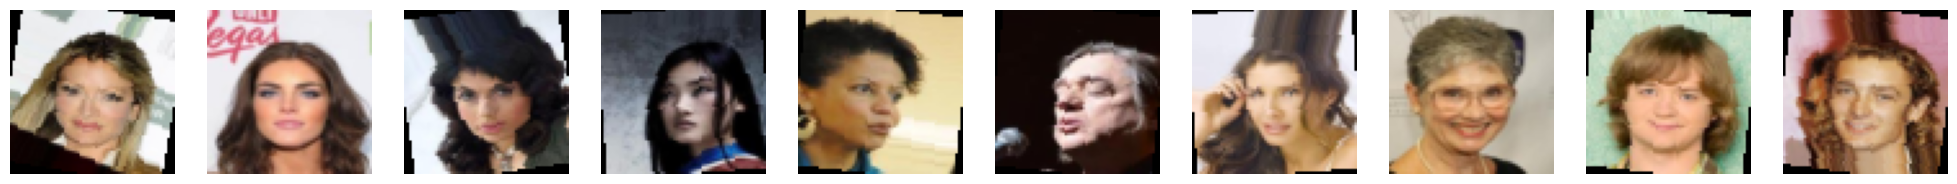

In [12]:
imgs = next(iter(train_loader))[0]

fig,ax=plt.subplots(1,10,figsize=(25, 4))

for i in range(10):
    ax[i].imshow(imgs[i].cpu().permute(1,2,0)*0.5 + 0.5)
    ax[i].axis("off")
plt.show()

## Conditional DC-GAN

In [13]:
class DCGenerator(nn.Module):
    """
    A fully convolutional generator using ReLU activations. 
    Takes as input a latent vector and outputs a fake sample.
       (B, latent_dim, 1, 1)  --> (B, num_channels, 32, 32)
    """
    def __init__(self, latent_dim=102, num_channels=1, base_channels=32):
        super().__init__()

        input_dim = latent_dim

        self.pixel_norm = PixelNorm()

        layers = []
        for i in range(4):
            layers.append(
                ConvTransposeBlock(
                    in_channels=input_dim if i == 0 else base_channels * 2 ** (3 - i + 1),
                    out_channels=base_channels * 2 ** (3 - i),
                    kernel_size=4,
                    stride=1 if i == 0 else 2,
                    add_norm=True,
                    activation="ReLU",
                    pad = 0 if i == 0 else 1
                )              
            )
        
        layers.append(
            ConvTransposeBlock(
                in_channels=base_channels,
                out_channels=num_channels,
                kernel_size=4,
                stride=2,
                add_norm=False,
                activation="Tanh"
            )
        )
        

        self.model = nn.Sequential(*layers)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        
    def forward(self, z):
        z = z.reshape([z.shape[0], -1, 1, 1])
        z = self.pixel_norm(z)
        return self.model(z)

In [14]:
generator = DCGenerator(latent_dim=128, num_channels=1, base_channels=32)
print(generator)

DCGenerator(
  (pixel_norm): PixelNorm()
  (model): Sequential(
    (0): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padd

In [15]:
class DCDiscriminator(nn.Module):
    """ A fully convolutional discriminator using LeakyReLU activations. 
    Takes as input either a real or fake sample and predicts its autenticity.
       (B, num_channels, 32, 32)  -->  (B, 1, 1, 1)
    """
    def __init__(self, in_channels=1, num_classes=10, out_dim=1, base_channels=32, dropout=0.3):
        super().__init__()

        input_channels = in_channels
        
        layers = []
        for i in range(4):
            layers.append(
                ConvBlock(
                    in_channels=input_channels if i == 0 else base_channels * 2 ** (i),
                    out_channels=base_channels * 2 ** (i +1 ),
                    kernel_size=4,
                    add_norm=True,
                    activation="LeakyReLU",
                    dropout=dropout,
                    stride=2
                )
            )
        layers.append(
            ConvBlock(
                in_channels=base_channels * 16,
                out_channels=out_dim,
                kernel_size=4,
                stride=1,
                add_norm=False,
                activation="Sigmoid",
                pad = 0
            )
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        
        return self.model(x)

In [16]:
discriminator = DCDiscriminator(in_channels=3, out_dim=1, base_channels=32)
print(discriminator)

DCDiscriminator(
  (model): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )

In [17]:
generator = DCGenerator(latent_dim=128, num_channels=3, base_channels=64,)
discriminator = DCDiscriminator(in_channels=3, out_dim=1, base_channels=64)

In [18]:
latent = torch.randn(16, 128, 1, 1)
fake_img = generator(latent)
print(fake_img.shape)
score = discriminator(fake_img)
print(f"{fake_img.shape = }")
print(f"{score.shape = }")

torch.Size([16, 3, 64, 64])
fake_img.shape = torch.Size([16, 3, 64, 64])
score.shape = torch.Size([16, 1, 1, 1])


## Training Code

In [19]:
class DCTrainer:
    """
    Class for initializing GAN and training it
    """
    def __init__(self, generator, discriminator, latent_dim=128, writer=None):
        assert writer is not None, "Tensorboard writer not set..."

        self.latent_dim = latent_dim
        self.writer = writer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)

        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.99), weight_decay=2e-5)
        # self.scheduler_discriminator = torch.optim.lr_scheduler.StepLR(self.optim_discriminator, step_size=5, gamma=0.9)
        self.optim_generator = torch.optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.99), weight_decay=2e-5)
        # self.scheduler_generator = torch.optim.lr_scheduler.StepLR(self.optim_generator, step_size=5, gamma=0.9)

        self.criterion_g = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.criterion_d_real = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.criterion_d_fake = lambda pred: F.binary_cross_entropy(pred, torch.zeros(pred.shape[0], device=pred.device))

        self.hist = {
            "d_real": [],
            "d_fake": [],
            "g": []
        }

    def train_one_step(self, imgs):
        self.generator.train()
        self.discriminator.train()

        B = imgs.shape[0]
        latent = torch.randn(B, self.latent_dim, 1, 1).to(self.device)

        self.optim_discriminator.zero_grad()
        prediction_real = self.discriminator(imgs)
        d_loss_real = self.criterion_d_real(prediction_real.view(B))

        fake_samples = self.generator(latent)
        prediction_fake_d = self.discriminator(fake_samples.detach())
        d_loss_fake = self.criterion_d_fake(prediction_fake_d.view(B))
        (d_loss_real + d_loss_fake).backward()

        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 3.0)
        self.optim_discriminator.step()

        self.optim_generator.zero_grad()
        prediction_fake_g = self.discriminator(fake_samples)
        g_loss = self.criterion_g(prediction_fake_g.view(B))
        g_loss.backward()

        self.optim_generator.step()

        return d_loss_real, d_loss_fake, g_loss

    @torch.no_grad()
    def generate(self, N=64):
        self.generator.eval()
        latent = torch.randn(N, self.latent_dim, 1, 1).to(self.device)
        imgs = self.generator(latent)
        imgs = imgs * 0.5 + 0.5
        return imgs

    def train(self, data_loader, N_epoch=10000, init_epoch=0):
        
        progress_bar = tqdm(total=N_epoch*(DATASET_SIZE//BATCH_SIZE), initial=init_epoch*(DATASET_SIZE//BATCH_SIZE))
        total_d_loss_real = []
        total_d_loss_fake = []
        total_gan_loss = []
        g_loss_curve = []
        d_loss_curve = []

        iter_ = 0
        for i in range(N_epoch):
            epoch_d_loss = []
            epoch_g_loss = []
            for real_batch, _ in data_loader:
                real_batch = real_batch.to(self.device)
                d_loss_real, d_loss_fake, g_loss = self.train_one_step(imgs=real_batch)
                d_loss = d_loss_real + d_loss_fake

                progress_bar.set_description(f"Ep {i+1} Iter {iter_} : D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")
                progress_bar.update(1)
                self.writer.add_scalar(f'Loss/Generator Loss', g_loss.item(), global_step=iter_)
                self.writer.add_scalar(f'Loss/Discriminator Loss', d_loss.item(), global_step=iter_)
                self.writer.add_scalars(f'Loss/Discriminator Losses', {
                    "Real Images Loss": d_loss_real.item(),
                    "Fake Images Loss": d_loss_fake.item(),
                }, global_step=iter_)
                self.writer.add_scalars(f'Comb_Loss/Losses', {
                    'Discriminator': d_loss.item(),
                    'Generator': g_loss.item()
                }, iter_)
                if(iter_ % 200 == 0):
                    imgs = self.generate()
                    grid = torchvision.utils.make_grid(imgs, nrow=8)
                    self.writer.add_image('images', grid, global_step=iter_)
                    torchvision.utils.save_image(grid, os.path.join(os.getcwd(), "Lab Work/CUDA_Assignment_6/imgs/DCGAN", "training", f"imgs_{iter_}.png"))

                total_d_loss_fake.append(d_loss_fake.item())
                total_d_loss_real.append(d_loss_real.item())
                total_gan_loss.append(g_loss.item())
                epoch_d_loss.append(d_loss.item())
                epoch_g_loss.append(g_loss.item())

                iter_ = iter_ + 1
            g_loss_curve.append(np.mean(epoch_g_loss))
            d_loss_curve.append(np.mean(epoch_d_loss))
            # self.scheduler_discriminator.step()
            # self.scheduler_generator.step()
        return total_d_loss_fake, total_d_loss_real, total_gan_loss, g_loss_curve, d_loss_curve

In [20]:

GAN_LOGS = os.path.join(os.getcwd(), "Lab Work/CUDA_Assignment_6/tboard_logs", "DCGAN")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [21]:
generator = DCGenerator(latent_dim=10, num_channels=3, base_channels=64)
discriminator = DCDiscriminator(in_channels=3, out_dim=1, base_channels=64)

DC_trainer = DCTrainer(generator=generator, discriminator=discriminator, latent_dim=10, writer=writer)

In [22]:
total_d_loss_fake, total_d_loss_real, total_gan_loss, g_loss_curve, d_loss_curve = DC_trainer.train(data_loader=train_loader, N_epoch=3)

  0%|                                                                                                                                      | 0/15258 [00:00<?, ?it/s]/home/user/krishnanm0/anaconda3/envs/CudaLab/lib/python3.8/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/user/krishnanm0/anaconda3/envs/CudaLab/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Ep 3 Iter 15257 : D_Loss=0.

In [23]:
total_d_loss = [total_d_loss_fake[i] + total_d_loss_real[i] for i in range(len(total_d_loss_fake))]
DCGAN_stats = [total_d_loss_fake, total_d_loss_real, total_gan_loss, g_loss_curve, d_loss_curve, total_d_loss]

/tmp/ipykernel_1858939/2587185209.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


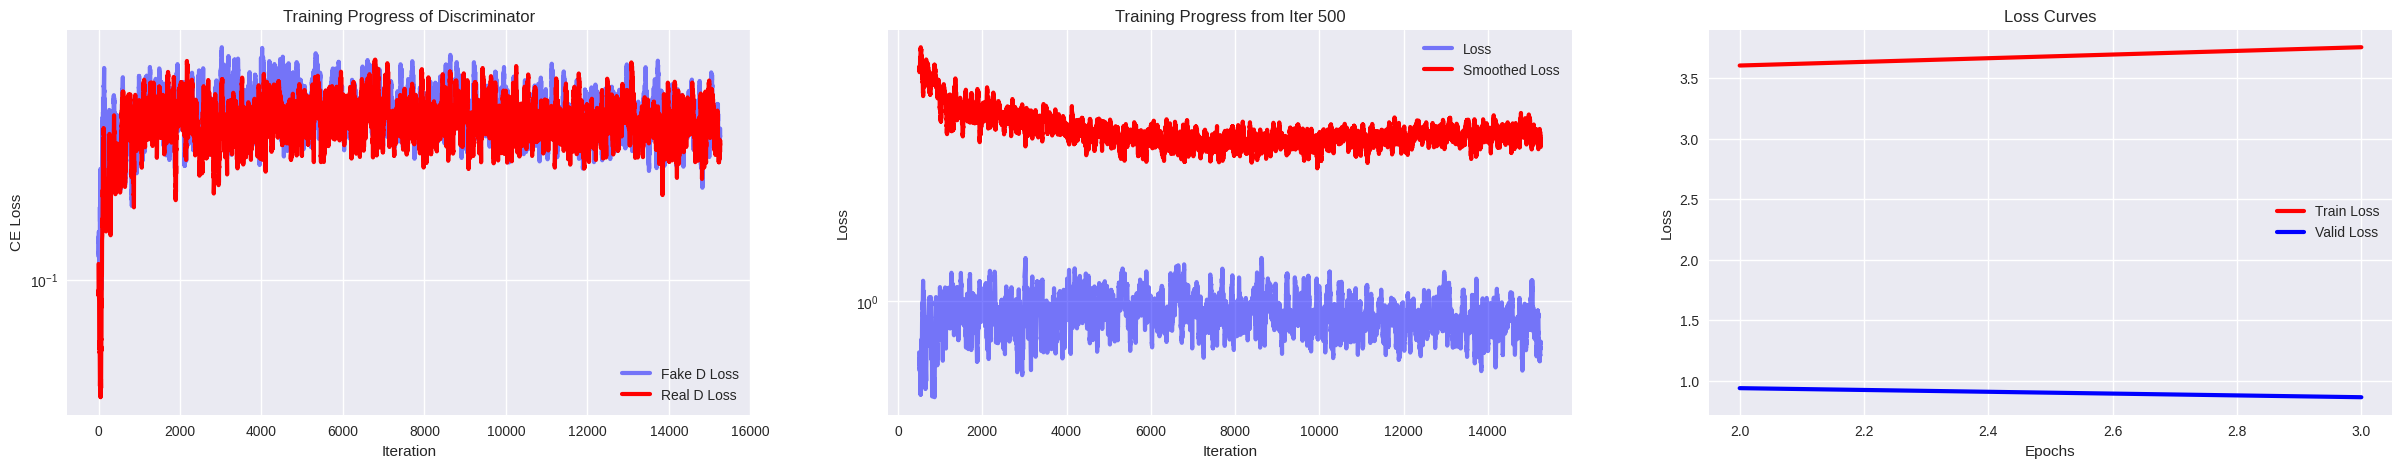

In [24]:
visualize_progress(total_d_loss_fake, total_d_loss_real, total_gan_loss, g_loss_curve, d_loss_curve, total_d_loss)

### Making gif

In [25]:
import imageio

images = []
img_path = os.path.join(os.getcwd(), "Lab Work/CUDA_Assignment_6/imgs/DCGAN", "training")

# making list with images and orting by iteration
img_list = [img for img in os.listdir(img_path) if "imgs_" in img]
sorted_imgs = sorted(img_list, key=lambda x: int(x.split("_")[1].split(".")[0]))

In [26]:
for img in sorted_imgs:
    images.append(imageio.imread(os.path.join(img_path, img)))
imageio.mimsave(os.path.join(img_path, "progress.gif"), images)

/tmp/ipykernel_1858939/2465386924.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(img_path, img)))


### Generating some Images

In [27]:
imgs = DC_trainer.generate()
grid = torchvision.utils.make_grid(imgs, nrow=8)
grid.shape

torch.Size([3, 530, 530])

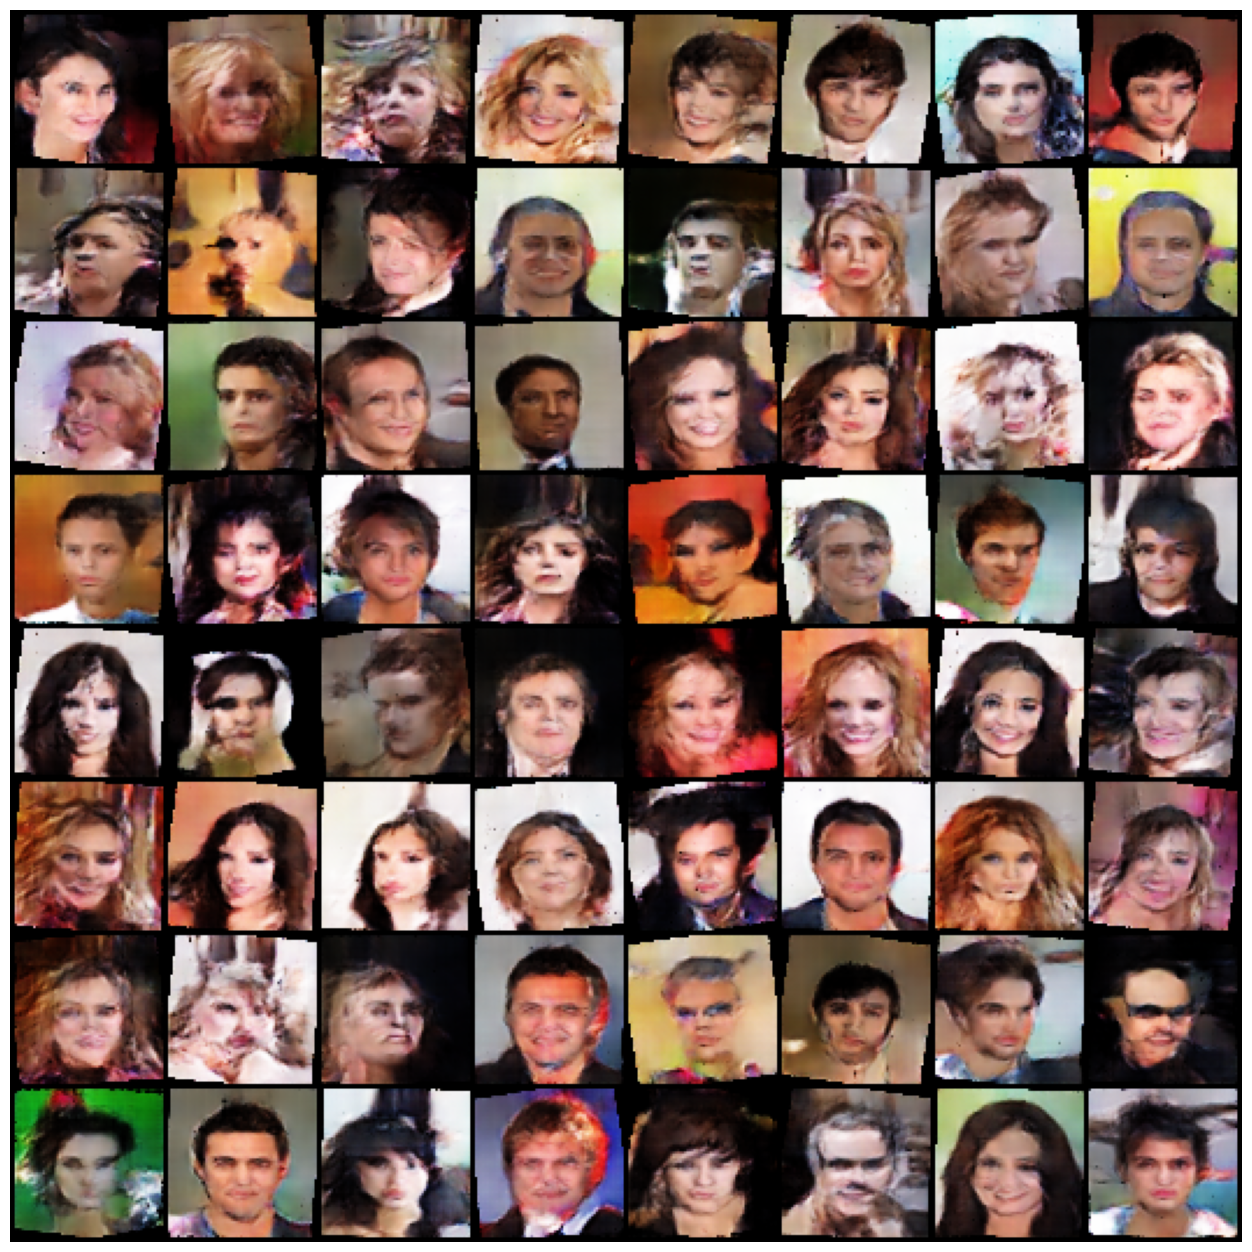

In [28]:
plt.figure(figsize=(16, 16))
plt.imshow(grid.cpu().permute(1, 2, 0))
plt.axis("off")
plt.show()

## SAGAN

In [29]:
if not os.path.exists("Lab Work/CUDA_Assignment_6/imgs/SAGAN"):
    os.makedirs("Lab Work/CUDA_Assignment_6/imgs/SAGAN")
if os.path.exists("Lab Work/CUDA_Assignment_6/imgs/SAGAN/training"):
    shutil.rmtree("Lab Work/CUDA_Assignment_6/imgs/SAGAN/training")
if not os.path.exists("Lab Work/CUDA_Assignment_6/imgs/SAGAN/training"):
    os.makedirs("Lab Work/CUDA_Assignment_6/imgs/SAGAN/training")

In [30]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.in_dim = in_dim
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        out = self.gamma * out + x
        return out, attention

In [31]:
class SAGANGenerator(nn.Module):
    """
    A fully convolutional generator using ReLU activations.
    Takes as input a latent vector and outputs a fake sample.
       (B, latent_dim, 1, 1)  --> (B, num_channels, 64, 64)
    """
    def __init__(self, latent_dim=128, num_channels=1, base_channels=32):
        super().__init__()

        input_dim = latent_dim

        self.pixel_norm = PixelNorm()

        layers = []
        self.attention_layer_idx = 2  # index of layer to add self-attention after

        for i in range(4):
            layers.append(
                ConvTransposeBlock(
                    in_channels=input_dim if i == 0 else base_channels * 2 ** (4 - i),
                    out_channels=base_channels * 2 ** (3 - i),
                    kernel_size=4,
                    stride=1 if i == 0 else 2,
                    add_norm=True,
                    activation="ReLU",
                    pad=0 if i == 0 else 1
                )
            )
            # Add self-attention layer after the specified transposed convolution layer
            if i == self.attention_layer_idx:
                layers.append(SelfAttention(base_channels * 2 ** (3 - i)))

        layers.append(
            ConvTransposeBlock(
                in_channels=base_channels,
                out_channels=num_channels,
                kernel_size=4,
                stride=2,
                add_norm=False,
                activation="Tanh"
            )
        )

        self.model = nn.Sequential(*layers)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, z):
        z = z.reshape([z.shape[0], -1, 1, 1])
        z = self.pixel_norm(z)

        for layer in self.model:
            if isinstance(layer, SelfAttention):
                z, _ = layer(z)
            else:
                z = layer(z)

        return z


In [32]:
class SAGANDiscriminator(nn.Module):
    """ 
    A fully convolutional discriminator using LeakyReLU activations.
    Takes as input either a real or fake sample and predicts its authenticity.
       (B, num_channels, 64, 64)  -->  (B, 1, 1, 1)
    """
    def __init__(self, in_channels=1, num_classes=10, out_dim=1, base_channels=32, dropout=0.3):
        super().__init__()

        input_channels = in_channels

        layers = []
        self.attention_layer_idx = 1  # index of layer to add self-attention after

        for i in range(4):
            layers.append(
                ConvBlock(
                    in_channels=input_channels if i == 0 else base_channels * 2 ** i,
                    out_channels=base_channels * 2 ** (i + 1),
                    kernel_size=4,
                    add_norm=True,
                    activation="LeakyReLU",
                    dropout=dropout,
                    stride=2
                )
            )
            # Add self-attention layer after the specified convolution layer
            if i == self.attention_layer_idx:
                layers.append(SelfAttention(base_channels * 2 ** (i + 1)))

        layers.append(
            ConvBlock(
                in_channels=base_channels * 16,
                out_channels=out_dim,
                kernel_size=4,
                stride=1,
                add_norm=False,
                activation="Sigmoid",
                pad=0
            )
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        for layer in self.model:
            if isinstance(layer, SelfAttention):
                x, _ = layer(x)
            else:
                x = layer(x)

        return x


In [33]:
generator = SAGANGenerator(latent_dim=128, num_channels=3, base_channels=64,)
discriminator = SAGANDiscriminator(in_channels=3, out_dim=1, base_channels=64)


In [34]:
latent = torch.randn(16, 128, 1, 1)
fake_img = generator(latent)
print(fake_img.shape)
score = discriminator(fake_img)
print(f"{fake_img.shape = }")
print(f"{score.shape = }")

torch.Size([16, 3, 64, 64])
fake_img.shape = torch.Size([16, 3, 64, 64])
score.shape = torch.Size([16, 1, 1, 1])


## Training Code

In [35]:
class SAGANTrainer:
    """
    Class for initializing GAN and training it
    """
    def __init__(self, generator, discriminator, latent_dim=128, writer=None):
        assert writer is not None, "Tensorboard writer not set..."

        self.latent_dim = latent_dim
        self.writer = writer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)

        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.99), weight_decay=2e-5)
        # self.scheduler_discriminator = torch.optim.lr_scheduler.StepLR(self.optim_discriminator, step_size=5, gamma=0.9)
        self.optim_generator = torch.optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.99), weight_decay=2e-5)
        # self.scheduler_generator = torch.optim.lr_scheduler.StepLR(self.optim_generator, step_size=5, gamma=0.9)

        self.criterion_g = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.criterion_d_real = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.criterion_d_fake = lambda pred: F.binary_cross_entropy(pred, torch.zeros(pred.shape[0], device=pred.device))

        self.hist = {
            "d_real": [],
            "d_fake": [],
            "g": []
        }

    def train_one_step(self, imgs):
        self.generator.train()
        self.discriminator.train()

        B = imgs.shape[0]
        latent = torch.randn(B, self.latent_dim, 1, 1).to(self.device)

        self.optim_discriminator.zero_grad()
        prediction_real = self.discriminator(imgs)
        d_loss_real = self.criterion_d_real(prediction_real.view(B))

        fake_samples = self.generator(latent)
        prediction_fake_d = self.discriminator(fake_samples.detach())
        d_loss_fake = self.criterion_d_fake(prediction_fake_d.view(B))
        (d_loss_real + d_loss_fake).backward()

        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 3.0)
        self.optim_discriminator.step()

        self.optim_generator.zero_grad()
        prediction_fake_g = self.discriminator(fake_samples)
        g_loss = self.criterion_g(prediction_fake_g.view(B))
        g_loss.backward()

        self.optim_generator.step()

        return d_loss_real, d_loss_fake, g_loss

    @torch.no_grad()
    def generate(self, N=64):
        self.generator.eval()
        latent = torch.randn(N, self.latent_dim, 1, 1).to(self.device)
        imgs = self.generator(latent)
        imgs = imgs * 0.5 + 0.5
        return imgs

    def train(self, data_loader, N_epoch=10000, init_epoch=0):
        
        progress_bar = tqdm(total=N_epoch*(DATASET_SIZE//BATCH_SIZE), initial=init_epoch*(DATASET_SIZE//BATCH_SIZE))
        total_d_loss_real = []
        total_d_loss_fake = []
        total_gan_loss = []
        g_loss_curve = []
        d_loss_curve = []

        iter_ = 0
        for i in range(N_epoch):
            epoch_d_loss = []
            epoch_g_loss = []
            for real_batch, _ in data_loader:
                real_batch = real_batch.to(self.device)
                d_loss_real, d_loss_fake, g_loss = self.train_one_step(imgs=real_batch)
                d_loss = d_loss_real + d_loss_fake

                progress_bar.set_description(f"Ep {i+1} Iter {iter_} : D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")
                progress_bar.update(1)
                self.writer.add_scalar(f'Loss/Generator Loss', g_loss.item(), global_step=iter_)
                self.writer.add_scalar(f'Loss/Discriminator Loss', d_loss.item(), global_step=iter_)
                self.writer.add_scalars(f'Loss/Discriminator Losses', {
                    "Real Images Loss": d_loss_real.item(),
                    "Fake Images Loss": d_loss_fake.item(),
                }, global_step=iter_)
                self.writer.add_scalars(f'Comb_Loss/Losses', {
                    'Discriminator': d_loss.item(),
                    'Generator': g_loss.item()
                }, iter_)
                if(iter_ % 200 == 0):
                    imgs = self.generate()
                    grid = torchvision.utils.make_grid(imgs, nrow=8)
                    self.writer.add_image('images', grid, global_step=iter_)
                    torchvision.utils.save_image(grid, os.path.join(os.getcwd(), "Lab Work/CUDA_Assignment_6/imgs/SAGAN", "training", f"imgs_{iter_}.png"))

                total_d_loss_fake.append(d_loss_fake.item())
                total_d_loss_real.append(d_loss_real.item())
                total_gan_loss.append(g_loss.item())
                epoch_d_loss.append(d_loss.item())
                epoch_g_loss.append(g_loss.item())

                iter_ = iter_ + 1
            g_loss_curve.append(np.mean(epoch_g_loss))
            d_loss_curve.append(np.mean(epoch_d_loss))
            # self.scheduler_discriminator.step()
            # self.scheduler_generator.step()
        return total_d_loss_fake, total_d_loss_real, total_gan_loss, g_loss_curve, d_loss_curve

In [36]:

GAN_LOGS = os.path.join(os.getcwd(), "Lab Work/CUDA_Assignment_6/tboard_logs", "SAGAN")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [37]:
generator = SAGANGenerator(latent_dim=10, num_channels=3, base_channels=64)
discriminator = SAGANDiscriminator(in_channels=3, out_dim=1, base_channels=64)

SAGAN_trainer = SAGANTrainer(generator=generator, discriminator=discriminator, latent_dim=10, writer=writer)

In [38]:
total_d_loss_fake, total_d_loss_real, total_gan_loss, g_loss_curve, d_loss_curve = SAGAN_trainer.train(data_loader=train_loader, N_epoch=3)

  0%|                                                                                                                                      | 0/15258 [00:00<?, ?it/s]

Ep 3 Iter 15257 : D_Loss=4.02462, G_Loss=1.0937): 100%|████████████████████████████████████████████████████████████████████████| 15258/15258 [15:47<00:00, 16.10it/s]


In [39]:
total_d_loss = [total_d_loss_fake[i] + total_d_loss_real[i] for i in range(len(total_d_loss_fake))]
SAGAN_stats = [total_d_loss_fake, total_d_loss_real, total_gan_loss, g_loss_curve, d_loss_curve, total_d_loss]

/tmp/ipykernel_1858939/2587185209.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


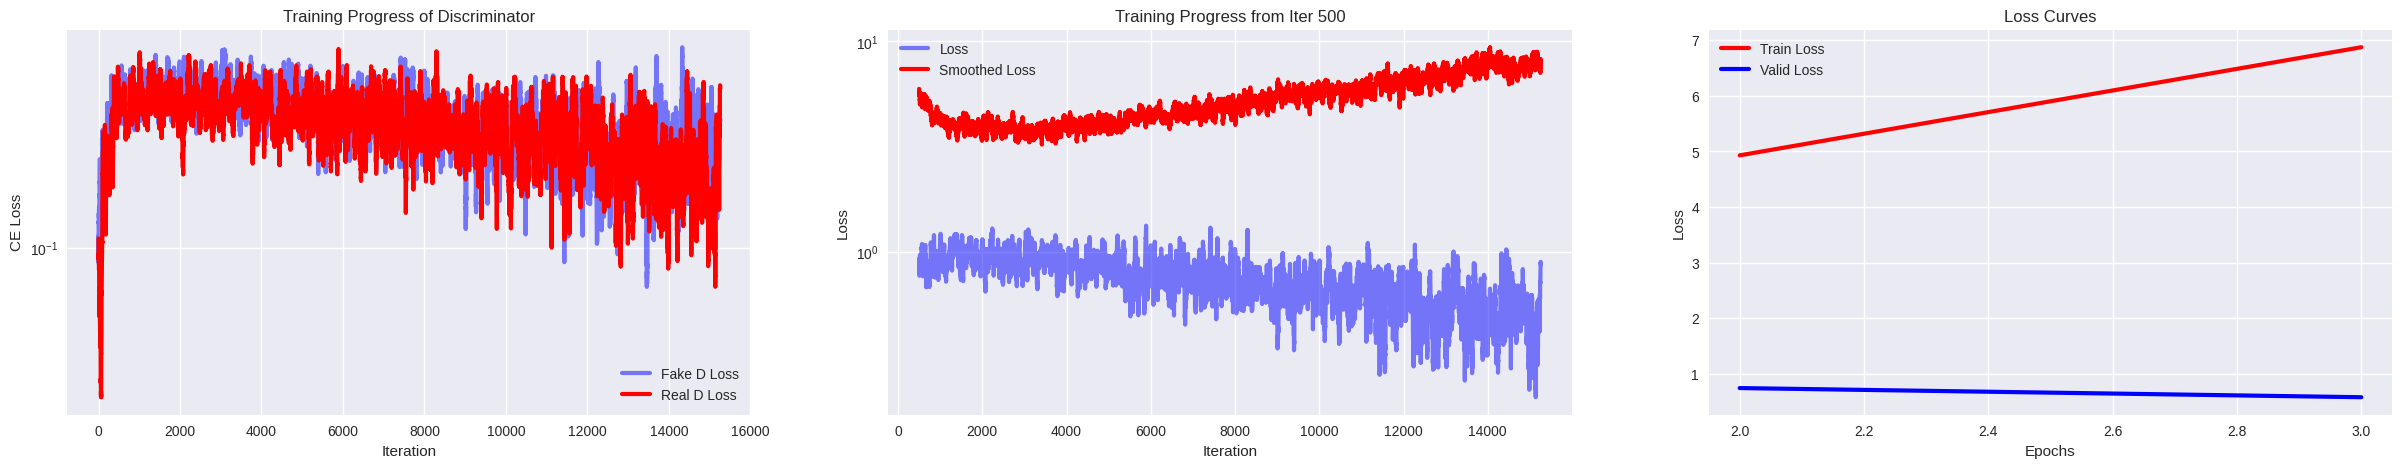

In [40]:
visualize_progress(total_d_loss_fake, total_d_loss_real, total_gan_loss, g_loss_curve, d_loss_curve, total_d_loss)

### Making gif

In [41]:
import imageio

images = []
img_path = os.path.join(os.getcwd(), "Lab Work/CUDA_Assignment_6/imgs/SAGAN", "training")

# making list with images and orting by iteration
img_list = [img for img in os.listdir(img_path) if "imgs_" in img]
sorted_imgs = sorted(img_list, key=lambda x: int(x.split("_")[1].split(".")[0]))

In [42]:
for img in sorted_imgs:
    images.append(imageio.imread(os.path.join(img_path, img)))
imageio.mimsave(os.path.join(img_path, "progress.gif"), images)

/tmp/ipykernel_1858939/2465386924.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(img_path, img)))


### Generating some Images

In [43]:
imgs = DC_trainer.generate()
grid = torchvision.utils.make_grid(imgs, nrow=8)
grid.shape

torch.Size([3, 530, 530])

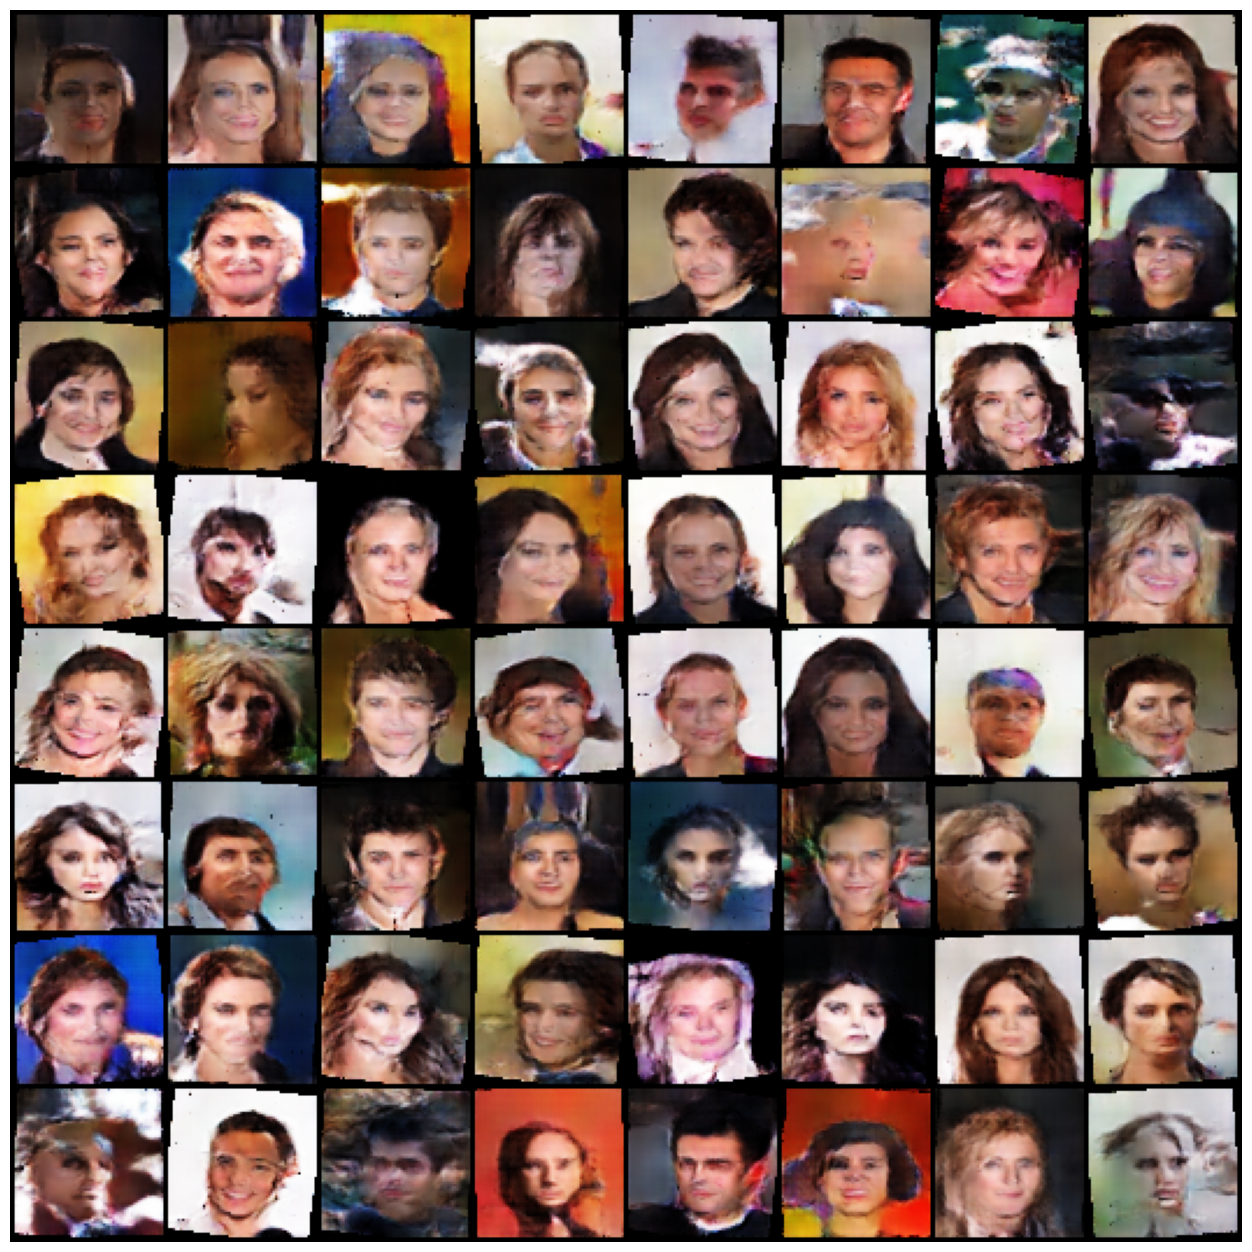

In [44]:
plt.figure(figsize=(16, 16))
plt.imshow(grid.cpu().permute(1, 2, 0))
plt.axis("off")
plt.show()